In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import  DataLoader,random_split
from torchvision import datasets,transforms
import torch.nn as nn

import sys
sys.path.append('/content/drive/MyDrive/mask-classfication')


In [ ]:
from CustomModel import MaskNet , MaskNetV2
from MaskDataset import MaskImageDataset
import numpy as np

import matplotlib.pyplot as plt

In [ ]:

import test as test

data_path = "/content/drive/MyDrive/mask-classfication/dataset.csv"
img_path = "/content/drive/MyDrive/mask-classfication/Dataset"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
#Loading Model 

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

full_dataset = MaskImageDataset(data_path, img_path, transform=transform)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=32, shuffle=True)
the_model = MaskNetV2()
the_model = the_model.to(device)
path = F"/content/drive/MyDrive/mask-classfication/saved_models/masknetv2_3_full.pt"
the_model=torch.load(path,torch.device('cpu'))
#the_model=torch.load("\content\drive\MyDrive\mask-classfication\saved_models\masknetv2_3_full.pt",torch.device('cpu'))

In [ ]:
from torch.nn.functional import cross_entropy
def test_model(model,testing_data,DEVICE):
    print('RBYRY')  
    testing_loss = 0
    correct_prediction = 0 
    data_size = 0
    prediction1=[]
     
    for images, labels in testing_data:
            images = images.to(device)
            labels = labels.to(device)          
            data_size += len(images)
            prediction = model(images)
            
            prediction1.append(prediction)
            
            testing_loss += cross_entropy(prediction, labels).item()
            correct_prediction += (prediction.argmax(dim=1) == labels).sum().item()

    

    accuracy = correct_prediction/data_size
    testing_loss = testing_loss/data_size

    print('\nTesting:')
    print(f"Correct prediction: {correct_prediction}/{data_size} and accuracy: {accuracy} and loss: {testing_loss}")
    #print(prediction1)
   



test_model(the_model,test_data,device)


Testing:
Correct prediction: 376/433 and accuracy: 0.8683602771362586 and loss: 0.015036814276120403


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def get_labels_N_prediction(model,loader,DEVICE):
    all_labels = []
    all_prediction = []

    for batch in loader:
        images, labels = batch
        images = images.to(DEVICE)

        prediction = model(images).to(torch.device("cpu")).argmax(dim=1).detach().numpy()
        labels = labels.to(torch.device("cpu")).detach().numpy()

        all_prediction = np.append(all_prediction,prediction)
        all_labels = np.append(all_labels,labels)

    return [all_labels,all_prediction]
# Evaluation
with torch.no_grad():
    labels_N_prediction = get_labels_N_prediction(the_model, test_data, device)

    
print(classification_report(labels_N_prediction[0], labels_N_prediction[1]))
conf_matrix = confusion_matrix(labels_N_prediction[0], labels_N_prediction[1])
print(conf_matrix)
  




              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90        78
         1.0       0.79      0.76      0.77        78
         2.0       0.85      0.86      0.86        80
         3.0       0.96      0.94      0.95        93
         4.0       0.92      0.90      0.91       104

    accuracy                           0.88       433
   macro avg       0.88      0.88      0.88       433
weighted avg       0.88      0.88      0.88       433

[[73  0  2  1  2]
 [ 3 59  8  2  6]
 [ 1  9 69  1  0]
 [ 2  2  2 87  0]
 [ 5  5  0  0 94]]


In [ ]:
#%%
import pandas as pd
#ACCURACY SCORE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import matplotlib
#y_pred = the_model.predict(test_dataset)
y_pred =labels_N_prediction[1]
y_test =labels_N_prediction[0]
print("Accuracy : ",accuracy_score(y_test, y_pred))



Accuracy :  0.8706697459584296


In [ ]:
#PRECISION , RECALL,FSCORE,SUPPORT
from sklearn.metrics import precision_recall_fscore_support
d=()
d=precision_recall_fscore_support(labels_N_prediction[0], y_pred)
prec = d[0].tolist()
recall = d[1].tolist()
fscore = d[2].tolist()
support = d[3].tolist()
#precision_recall_fscore_support(y_test, y_pred,average="macro")
print("prec --",prec)
print("recall --",recall)
print("fscore --",fscore)
print("support --",support)



prec -- [0.8282828282828283, 0.7816091954022989, 0.88, 1.0, 0.8804347826086957]
recall -- [0.845360824742268, 0.8292682926829268, 0.8918918918918919, 0.963855421686747, 0.8350515463917526]
fscore -- [0.836734693877551, 0.8047337278106508, 0.8859060402684563, 0.9815950920245399, 0.8571428571428571]
support -- [97, 82, 74, 83, 97]


              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84        97
         1.0       0.78      0.83      0.80        82
         2.0       0.88      0.89      0.89        74
         3.0       1.00      0.96      0.98        83
         4.0       0.88      0.84      0.86        97

    accuracy                           0.87       433
   macro avg       0.87      0.87      0.87       433
weighted avg       0.87      0.87      0.87       433



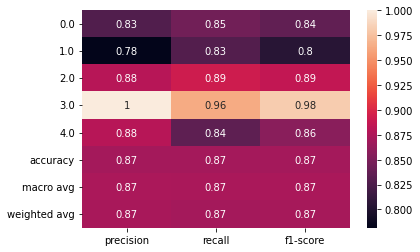

In [ ]:
#CLASSIFICATION REPORT - PRECISION , RECALL,FSCORE,SUPPORT
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

#PLOTTING CLASSIFICATION REPORT
import seaborn as sns
from pylab import savefig
h= classification_report(y_test, y_pred , output_dict=True)
svm =sns.heatmap(pd.DataFrame(h).iloc[:-1, :].T, annot=True)
figure = svm.get_figure()

figure.savefig('Classification report.png')

    


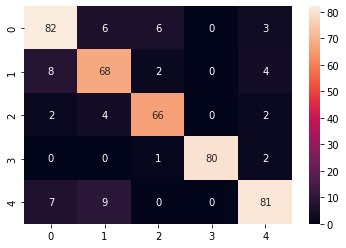

<Figure size 432x288 with 0 Axes>

In [ ]:
#CONFUSION MATRIX & PLOTTING IT
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
confusion_matrix = confusion_matrix(y_test, y_pred).tolist()
cm = sns.heatmap(confusion_matrix, annot=True, fmt='d')


cm.plot()
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('confusion metrics.png')


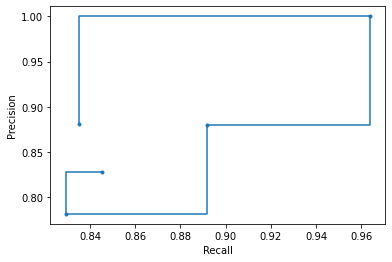

<Figure size 432x288 with 0 Axes>

In [ ]:
#PLOTTING PRECISION AND RECALL GRAPH
from sklearn.metrics import PrecisionRecallDisplay

disp = PrecisionRecallDisplay(precision=precision_recall_fscore_support(y_test, y_pred)[0],recall=precision_recall_fscore_support(y_test, y_pred)[1])
disp.plot( marker='.')
matplotlib.pyplot.show()
matplotlib.pyplot.savefig('Precision vs Recall.png')
# %%

Prediction : No Mask


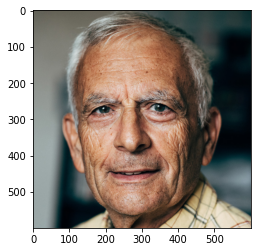

In [ ]:
import torch

from torchvision import transforms
from PIL import Image



def predictImage(model, imagePath, device, labels={0:'cloth', 1:'N95', 2:'N95 with valve', 3:'No Mask', 4:'Surgical'}):
    
    
    transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])
    image = Image.open(imagePath).convert('RGB')
    imageD = Image.open(imagePath).convert('RGB')
    
    image = transform(image)
    
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
    pred = output.argmax(dim=1).cpu().numpy()
    #print(pred)
    
    plt.imshow(imageD)    
    print("Prediction : " + labels[pred[0]])
    
img_path = "/content/drive/MyDrive/mask-classfication/Dataset/NoMask-292.png"

predictImage(the_model, img_path, "cpu")